In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import h5py

from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
#from google.colab import files
#uploaded = files.upload()

In [0]:
def implt(img):
    plt.figure()
    plt.imshow(img)
    plt.axis('off')

In [0]:
                            # Set up 'ggplot' style
plt.style.use('ggplot')     # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['font.family']     = 'Arial'

In [14]:
def read_data_set(h5_file='out.h5'):
    with h5py.File(h5_file, 'r') as hf:
        X_train = hf['X_train'].value
        print('Read X_train: ', X_train.shape)        
        
        y_train = hf['y_train'].value
        print('Read y_train: ', y_train.shape)        
        
        X_test = hf['X_test'].value
        print('Read X_test: ', X_test.shape)        
        
        y_test = hf['y_test'].value
        print('Read y_test: ', y_test.shape)        
    
    return (X_train, y_train, X_test, y_test)

X_train_data, y_train_data, X_test_data, y_test_data = read_data_set(h5_file='/content/drive/My Drive/Colab/ca2data.h5' )

Read X_train:  (2067, 128, 128, 3)
Read y_train:  (2067,)
Read X_test:  (1034, 128, 128, 3)
Read y_test:  (1034,)


In [0]:
#data            = cifar10.load_data()
(trDat, trLbl)  = X_train_data, y_train_data
(tsDat, tsLbl)  = X_test_data, y_test_data


                            # Convert the data into 'float32'
                            # Rescale the values from 0~255 to 0~1
trDat       = trDat.astype('float32')/255
tsDat       = tsDat.astype('float32')/255


                            # Retrieve the row size of each image
                            # Retrieve the column size of each image
imgrows     = trDat.shape[1]
imgclms     = trDat.shape[2]
channel     = trDat.shape[3]


                            # Perform one hot encoding on the labels
                            # Retrieve the number of classes in this problem
trLbl       = to_categorical(trLbl)
tsLbl       = to_categorical(tsLbl)
num_classes = tsLbl.shape[1]

In [16]:
                            # fix random seed for reproducibility
seed        = 42
np.random.seed(seed)

optmz       = optimizers.Adam(lr=0.001)
modelname   = 'PRMLS_CA2'
                            # define the deep learning model

def resLyr(inputs,
           numFilters=16,
           kernelSz=3,
           strides=1,
           activation='relu',
           batchNorm=True,
           convFirst=True,
           lyrName=None):
  convLyr = Conv2D(numFilters,
                  kernel_size=kernelSz,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4),
                  name=lyrName+'_conv' if lyrName else None)
  x = inputs
  if convFirst:
    x = convLyr(x)
    if batchNorm:
      x = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
    if activation is not None:
      x = Activation(activation,name=lyrName+'_'+activation if lyrName else None)(x)
  else:
    if batchNorm:
      x = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
    if activation is not None:
      x = Activation(activation,name=lyrName+'_'+activation if lyrName else None)(x)
    x = convLyr(x)

  return x


def resBlkV1(inputs,
             numFilters=16,
             numBlocks=7,
             downsampleOnFirst=True,
             names=None):
  x = inputs
  for run in range(0,numBlocks):
    strides = 1
    blkStr = str(run+1)
    if downsampleOnFirst and run == 0:
      strides = 2
    y = resLyr(inputs=x,
              numFilters=numFilters,
              strides=strides,
              lyrName=names+'_Blk'+blkStr+'_Res1' if names else None)
    y = resLyr(inputs=y,
              numFilters=numFilters,
              activation=None,
              lyrName=names+'_Blk'+blkStr+'_Res2' if names else None)
    if downsampleOnFirst and run == 0:
      x = resLyr(inputs=x,
                numFilters = numFilters,
                kernelSz=1,
                strides=strides,
                activation=None,
                batchNorm=False,
                lyrName=names+'_Blk'+blkStr+'_lin' if names else None)
    x = add([x,y],
           name=names+'_Blk'+blkStr+'_add' if names else None)
    x  = Activation('relu',
                   name=names+'_Blk'+blkStr+'_relu' if names else None)(x)
     
  return x
    

def createResNetV1(inputShape=(128,128,3),
                   numClasses=3):
  inputs = Input(shape=inputShape)
  v = resLyr(inputs,
            lyrName='Input')
  
  v = Dropout(0.2)(v)
  
  v = resBlkV1(inputs=v,
              numFilters=16,
              numBlocks=7,
              downsampleOnFirst=False,
              names='Stg1')
  
  v = Dropout(0.2)(v)
  
  v = resBlkV1(inputs=v,
              numFilters=32,
              numBlocks=7,
              downsampleOnFirst=True,
              names='Stg2')
  
  v = Dropout(0.2)(v)
  
  v = resBlkV1(inputs=v,
              numFilters=64,
              numBlocks=7,
              downsampleOnFirst=True,
              names='Stg3')
  
  v = Dropout(0.2)(v)
  
  v = resBlkV1(inputs=v,
              numFilters=128,
              numBlocks=7,
              downsampleOnFirst=True,
              names='Stg4')
  
  v = Dropout(0.2)(v)
  
  v = AveragePooling2D(pool_size=8,
                      name='AvgPool')(v)
  
  v = Dropout(0.2)(v)
  
  v = Flatten()(v)
  outputs = Dense(numClasses,
                 activation='softmax',
                 kernel_initializer='he_normal')(v)
  model = Model(inputs=inputs,outputs=outputs)
  model.compile(loss='categorical_crossentropy',
               optimizer=optmz,
               metrics=['accuracy'])
    
  return model


                                # Setup the models
model       = createResNetV1()  # This is meant for training
modelGo     = createResNetV1()  # This is used for final testing

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Input_conv (Conv2D)             (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
Input_bn (BatchNormalization)   (None, 128, 128, 16) 64          Input_conv[0][0]                 
__________________________________________________________________________________________________
Input_relu (Activation)         (None, 128, 128, 16) 0           Input_bn[0][0]                   
______________________________________________________________________________________________

In [0]:
def lrSchedule(epoch):
    lr  = 1e-3
    
    if epoch > 160:
        lr  *= 0.5e-3
        
    elif epoch > 140:
        lr  *= 1e-3
        
    elif epoch > 120:
        lr  *= 1e-2
        
    elif epoch > 80:
        lr  *= 1e-1
        
    print('Learning rate: ', lr)
    
    return lr

LRScheduler     = LearningRateScheduler(lrSchedule)

                            # Create checkpoint for the training
                            # This checkpoint performs model saving when
                            # an epoch gives highest testing accuracy
filepath        = '/content/drive/My Drive/Colab/' + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_acc', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger('/content/drive/My Drive/Colab/' + modelname +'.csv')
callbacks_list  = [checkpoint,csv_logger,LRScheduler]

In [18]:
                            # Fit the model
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             rotation_range=20,
                             horizontal_flip=True,
                             vertical_flip=False)

model.fit_generator(datagen.flow(trDat, trLbl, batch_size=32),
                    validation_data=(tsDat, tsLbl),
                    epochs=200, #originally 200
                    verbose=1,
                    steps_per_epoch=len(trDat)/32,
                    callbacks=callbacks_list)

Learning rate:  0.001
Epoch 1/200
65/64 [==============================] - 101s 2s/step - loss: 2.4236 - acc: 0.4151 - val_loss: 9.0405 - val_acc: 0.3482
Learning rate:  0.001
Epoch 2/200
65/64 [==============================] - 46s 715ms/step - loss: 1.8928 - acc: 0.4427 - val_loss: 1.9190 - val_acc: 0.3395
Learning rate:  0.001
Epoch 3/200
65/64 [==============================] - 47s 719ms/step - loss: 1.7454 - acc: 0.5036 - val_loss: 1.9861 - val_acc: 0.3424
Learning rate:  0.001
Epoch 4/200
65/64 [==============================] - 47s 721ms/step - loss: 1.7084 - acc: 0.5138 - val_loss: 2.2107 - val_acc: 0.3443
Learning rate:  0.001
Epoch 5/200
65/64 [==============================] - 48s 744ms/step - loss: 1.6956 - acc: 0.5046 - val_loss: 1.7500 - val_acc: 0.4130
Learning rate:  0.001
Epoch 6/200
65/64 [==============================] - 49s 749ms/step - loss: 1.6399 - acc: 0.5288 - val_loss: 1.7874 - val_acc: 0.4410
Learning rate:  0.001
Epoch 7/200
65/64 [=========================

In [0]:
                            # Now the training is complete, we get
                            # another object to load the weights
                            # compile it, so that we can do 
                            # final evaluation on it
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer=optmz, 
                metrics=['accuracy'])

                            # Make classification on the test dataset
predicts    = modelGo.predict(tsDat)

In [20]:
                            # Prepare the classification output
                            # for the classification report
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(tsLbl,axis=1)
labelname   = ['cat',
               'bird',
               'dog']
                                            # the labels for the classfication report

testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)

print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=labelname,digits=4))
print(confusion)

Best accuracy (on testing dataset): 76.31%
              precision    recall  f1-score   support

         cat     0.8442    0.7507    0.7947       361
        bird     0.6727    0.9309    0.7810       362
         dog     0.8538    0.5820    0.6922       311

    accuracy                         0.7631      1034
   macro avg     0.7902    0.7545    0.7560      1034
weighted avg     0.7870    0.7631    0.7591      1034

[[271  70  20]
 [ 14 337  11]
 [ 36  94 181]]


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


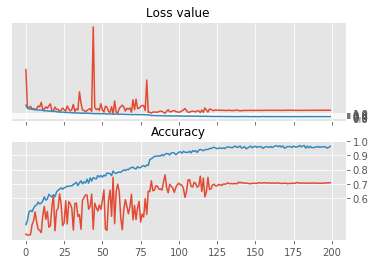

In [22]:
import pandas as pd

records     = pd.read_csv('/content/drive/My Drive/Colab/' + modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0,0.20,0.40,0.60,0.80,1.00])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_acc'])
plt.plot(records['acc'])
plt.yticks([0.6,0.7,0.8,0.9,1.0])
plt.title('Accuracy',fontsize=12)
plt.show()

#from tensorflow.keras.utils import plot_model

#plot_model(model, 
           #to_file=modelname+'_model.pdf', 
           #show_shapes=True, 
           #show_layer_names=False,
           #rankdir='TB')